# Lab 3 

The aim of the Lab is to learn to simulate the paths of solutions of stochastic differential equations corresponding to common stock market models.

## Brownian motion

Brownian motion is a continuous (that is, with continuous trajectories) stochastic process which is widely used for modelling continuous time processes. All stock market models we consider in this course use Brownian motion as a source of randomness. The main features of (standard) Brownian motion (or Wiener process) are as follows:

* $B(0)=0$ (start from zero)
* The increments $B(t_2)-B(t_1),\ t_2>t_1$ are normally distributed with mean 0 and standard deviation $\sqrt{t_2-t_1}$
* For non-intersecting intervals $(t_1,t_2)$ and $(t_3,t_4)$ the increments $B(t_2)-B(t_1)$ and $B(t_4)-B(t_3)$ are independent random variables

The properties of Brownian motion make it easy to generate values for a trajectory at some time moments $t_0=0, t_1=h,\ldots,t_m=m\cdot h$, where $h$ is a step size and $m$ is the number of time steps. Usually $h$ is defined by $\frac{T}{m}$, where $T$ is a given final time. It makes sense to store the computed values $B(t_0),B(t_1),\ldots,B(t_m)$ in a NumPy vector `B` with $m+1$ elements. Let us do that step by step.

First, import the libraries numpy (with short name `np`) and pylab (with short name `pl`).

In [1]:
import numpy as np
import pylab as pl

Define variables `T`,`m` with values $0.5$ and $10$ and compute the step size `h`.

In [2]:
# define T
T = .5 

# define m
m = 10

# compute h
h = T/m 

Now define a vector `B`, containing $m+1$ zeros.

In [3]:
B = np.zeros(m+1)
B

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

According to the properties of Brownian motion we can, after computing the value of $B(t_{i-1})$ (which we store in the vector `B` at the position with index $i-1$), compute the value of $B(t_{i})$ by adding a normally distributed random value $X_i$ to the value of $B(t_{i-1})$. So we compute `B[i] = B[i-1] + X_i` one by one for $i=1,2,\ldots,m$. The random value `X_i` should come from the distribution $N(0,sd=\sqrt{h})$, but it is known that we get such value by generating a value `Z_i` from the standard normal distribution and multiplying it by $\sqrt{h}$. If we have to compute values one by one in a definite order, it is appropriate to use `for` cycle. Complete the code below.

In [4]:
for i in range(1, m+1):
    X_i = np.sqrt(h)*np.random.randn(1)
    B[i] = B[i-1] + X_i
B

array([ 0.        , -0.11927003, -0.12465766, -0.33021251,  0.25760837,
        0.25412576,  0.3246728 ,  0.44498842,  0.67068662,  0.51356043,
        0.53949711])

Let us draw the graph, connecting generated values by stright line segments.

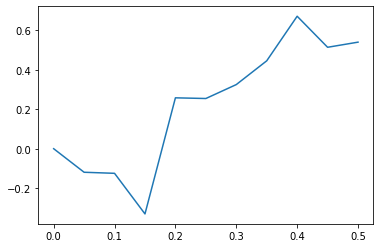

In [5]:
timepoints = np.linspace(0, T, m+1)
pl.plot(timepoints, B)

If our step by step computations work, we can easily make a function which allows easily to change the parameters `m` and `T`. Let us define a function Brownian(m,T), which draws the graph of a trajectory of Brownian motion.

In [6]:
def Brownian(m, T):
    B = np.zeros(m+1)
    h = T/m
    for i in range(1, m+1):
        X_i = np.sqrt(h)*np.random.randn(1)
        B[i] = B[i-1] + X_i
    timepoints = np.linspace(0, T, m+1)
    pl.plot(timepoints, B)

Try it out with the following commands. The result should agree exactly with the graph shown below

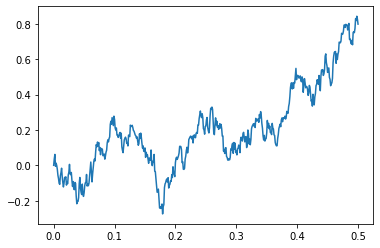

In [7]:
np.random.seed(198775) #use this command only if you want to eliminate randomness for comparing results
Brownian(500, .5)

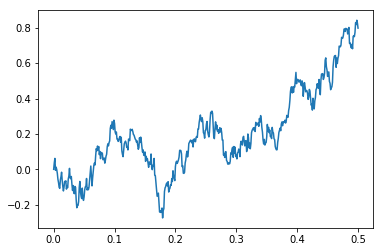

Often we want to see several possible trajectories at the same time. 

One possibility is to store the $m+1$ values corresponding to each of the $n$ different trajectories in a matrix `B_matrix` so that each trajectory is in a different column (and each row corresponds to one of the time points $t_i$). 

Instead of doing computations by trajectories, i.e., generating all values of the first trajectory and storing the result in the first column, then computing the values of the second trajectory and storing the result in the second column and so on, it is better to do computations by time moments.

The time moments are rows of the matrix: compute the values of corresponding to $t_1$ (the second row) for all trajectories, then compute the values corresponding to $t_2$ and so on. 

This is better since the values in different columns are not related to each other and therefore they can be computed by using vector operations. 

After computing the values for the $(i-1)$-th row, we generate $n$ different random numbers together as a vector and compute the values in the $i$-th row by adding the numbers to the values in the previous row. 

Fortunately, it is very easy to change the code which computes one trajectory to code which computes $n$ trajectories - we just have to change `B` to matrix, `X_i` to a vector of $n$ values and use vector operations for computing the next row from the previous one. 

Please complete the code below so that it produces a graph of $n$ trajectories.

In [8]:
def Brownian2(m, T, n):
    h = T/m
    B = np.zeros(shape = (m+1, n))
    for i in range(1, m+1):
        X_i = np.sqrt(h)*np.random.randn(n) # different value for each column
        B[i, :] = B[i-1, :] + X_i
    timepoints = np.linspace(0, T, m+1)
    pl.plot(timepoints, B)

Check the code (the result should be exactly the same as on a graph below):

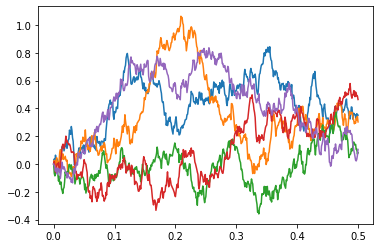

In [9]:
np.random.seed(198775) # use this command only if you want to eliminate randomness for comparing results
Brownian2(500, .5, 5)

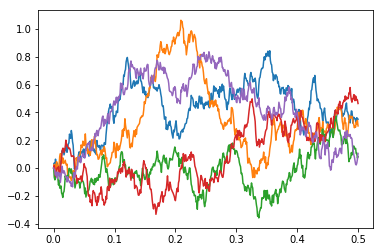

## Euler-Maruyama method for BS market model

Sometimes it is important to know how to simulate the stock price trajectories corresponding to a market model, especially for applying Monte-Carlo methods. 

A simple and quite universal (but often not the best) way to generate the trajectories of solutions of stochastic differential equations is the Euler-Maruyama method, where differentials are replaced by differences over small time intervals $(t_{i-1},t_{i})$ and all other values on the right hand side are taken at the time moment $t_{i-1}$. 

The same idea applies for one equation and for a system of equations.

For Black-Scholes market model
$$dS(t)=S(t)\big(\,\mu(t)\,dt+\sigma(S(t),t)\,dB(t)\,\big)$$
this leads to an approximation

$$S(t_i)-S(t_{i-1})\approx S(t_{i-1})\big(\,\mu(t_{i-1})\,h_i+\sigma(S(t_{i-1}),t_{i-1})\,(B(t_i)-B(t_{i-1}))\,\big),$$

where $0=t_0<t_1<\ldots<t_m=T$ is a partition of the interval $[0,T]$ into (usually equal) subintervals and $h_i=t_i-t_{i-1}$. 

If the time intervals are equal, we can use the single value $h=\frac{T}{m}$ instead of $h_i$. 

Using this approximation, the knowledge that $B(t_i)-B(t_{i-1})\sim N(0,\sqrt{h_i})$ and a given value of $S_0=S(0)$ we can compute approximate values $S_1,S_2,\ldots,S_m$ 
of 
$S(t_1),S(t_2),\ldots,S(t_m)$ by

\begin{align*}S_i&=S_{i-1}+S_{i-1}\,\big(\mu(t_{i-1})\,h_i+\sigma(S_{i-1},t_{i-1})\sqrt{h_i}X_i\big)\\
\\ &=S_{i-1}\,\big(1+\mu(t_{i-1})\,h_i+\sigma(S_{i-1},t_{i-1})\sqrt{h_i}X_i\big),\ i=1,\ldots,m,\end{align*}

where $X_i$ are independent random variables from the standard normal distribution. 

## Exercise 1
 Write a function `BSgraph(S0, n, m, mu, sigma, T)` that plots the graph of $n$ trajectories of the stock price on the interval $[0,T]$, corresponding to the Black-Scholes market model with constant parameters $\mu$ and $\sigma$. For computing the values of the stock prices divide the interval $[0,T]$ into $m$ equal subintervals (ie. use the time points $t_i=\frac{i\cdot T}{m},\ i=0,1,\ldots, m$) and use the Euler's method.
 
**Hint** The code should be quite similar to the function Brownian2.

In [10]:
def BSgraph(S0, n, m, mu, sigma, T):
    h = T/m
    S = np.zeros(shape = (m+1, n))
    
    # fill the first row (with index 0) with starting values
    S[0, :] = S0 
    
    for i in range(1, m+1):
        X_i = np.random.randn(n)
        S[i, :] = S[i-1, :]*(1 + mu*h + sigma*np.sqrt(h)*X_i)
    timepoints = np.linspace(0, T, m+1)
    pl.plot(timepoints, S)

Check the result (the output should be exactly the same as on the graph below)

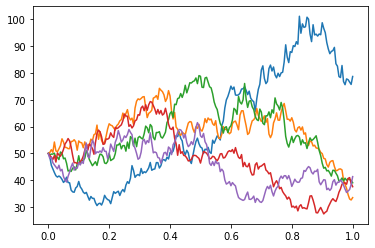

In [11]:
np.random.seed(20200226)
BSgraph(S0 = 50, n = 5, m = 200, mu = .1, sigma = .5, T = 1)

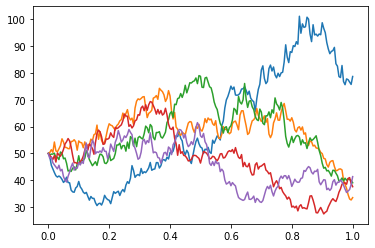

## Exercise 2
In the case of pricing European options by Monte-Carlo methods, we do not want to look at the trajectories of the stock prices but need only to generate values of $S(T)$. 

Define a function  `ST(S0, n, m, mu, sigma, T)` that returns a vector of $n$ randomly generated values of $S(T)$ according to BS market model with constant $\mu$ and non-constant volatility given by a function $\sigma(s,t)$. 

Compute the mean value and standard deviation of 100,000 generated stock prices at time $t=T$ in the case $\mu=0.05,\, m=100,\, S_0=10,\, T=1$ and $\sigma(s,t)=\frac{e^{-0.1\cdot t}}{1+0.005 s^2}$. 

**Solution**

First define the parameters and the function $\sigma$.

In [12]:
# define mu, m, S0,T
def sigma(s, t):
    return (np.exp(-.1*t)/(1 + .005*s**2))

Check that the volatility function works correctly:

In [13]:
sigma(s = np.array([9, 12]), t = .2) #should be array([0.6976503 , 0.56988295])

array([0.6976503 , 0.56988295])

Define the function ST (should be similar to BSgraph, but `sigma` should use parameters `s = S[i-1, :]` and `t = t[i-1]`, where the vector `t` should contain the time moments the code is using.

In [14]:
def ST(S0, n, m, mu, sigma, T):
    """
    generator of final stock prices S(T) in the case of BS market model
    sigma should be a function of two variables
    """
    h = T/m
    S = np.zeros(shape = (m+1, n))
    S[0, :] = S0
    t = np.linspace(0, T, m+1)
    for i in range(1, m+1):
        X_i = np.random.randn(n)
        S[i, :] = S[i-1, :]*(1 + mu*h + sigma(S[i-1, :], t[i-1])*np.sqrt(h)*X_i)
    return S[m, :]

Check the result:

In [15]:
result = ST(n = 100000, S0 = 10, mu = .05, m = 100, T = 1, sigma = sigma)
print("mean:", np.mean(result)) # should be approximately 10.5
print("standard deviation:", np.std(result)) # should be approximately 6.1

mean: 10.528190660940792
standard deviation: 6.096338848306178


## Exercise 3
Often we have several stochastic processes in a market model. 

Consider a model with stochastic interest rate:
\begin{align*}
dS(t)&=S(t)(r(t)\,dt+0.5 dB_1(t)),\\
\\
dr(t)&=(0.05-r(t))\,dt+0.02 \,dB_2(t),
\end{align*}

where $B_1$ and $B_2$ are independent Brownian motions. 

Use Euler-Maruyama method for defining a function that for given $n$ and $m$ outputs $n$ generated values of $S(0.5)$ in the case $S(0)=100,\ r(0)=0.04.$ 

Compute the approximate expected value of $S(0.5)$ by using the output of the function in the case $m=100,\ n=100,000$

**Solution**

The first step to complete the exercise is to derive formulas for computing approximate values of $S(t_i)$ and $r(t_i)$ according to Euler-Maruyama method. Assume that those values are stored in vectors `S` and `r`, respectively. The equation for computing stock prices is derived as follows:

First, replace $dS(t)$ with difference $S_i-S_{i-1}$ and use everything on the right hand side at the time moment $t_{i-1}$: 

$$S_i-S_{i-1}=S_{i-1}\cdot(r_{i-1}\cdot h+0.5\cdot \sqrt{h}\cdot X_{1,i}),$$

where $h=\frac{T}{m}$ and $X_{1,i}$ are values from the standard normal distribution used in the first equation. 

Now we write the equation so that $S_i$ is on the left hand side and everything else is on the right hand side:

$$S_i=S_{i-1}+S_{i-1}\cdot(r_{i-1}\cdot h+0.5\cdot \sqrt{h}\cdot X_{1,i}).$$

Since both terms on the right hand side contain a common factor $S_{i-1}$, the equation is usually written in the form

$$S_i=S_{i-1}\cdot(1+r_{i-1}\cdot h+0.5\cdot \sqrt{h}\cdot X_{1,i}).$$

When translating this equation into Python code which computes $n$ trajectories of stock prices and interest rates (which we store as matrices), the mathematical notation $S_i$ is translated to `S[i, :]`, 

$r_{i-1}$ is translated to `r[i-1, :]` and so on (since we are using vector operations to compute a full row with a single line).

Now derive a corresponding equation for computing interest rates.


After deriving the equations, it should be relatively easy to solve the exercise. The function should have only two input parameters $m$ and $n$. Other parameters $(T, S0,r0)$ we can either define outside of the function (then the current values of the parameters are used when the function is called) or inside the function (this is safer since correct parameters are always used but not very convenient if we want to repeat the computations with many different values of the parameters). 

Use the second approach for solving this exercise.

In [16]:
def Ex3(m, n):
    # parameters fixed in the problem
    T = .5
    S0 = 100
    r0 = .04
    dt = T/m
    sigma = .5
    S = np.zeros(shape = (m+1, n))
    r = np.zeros(shape = (m+1, n))
    S[0, :] = S0
    r[0, :] = r0
    for i in range(1, m+1):
        X_i1 = np.random.randn(n)
        X_i2 = np.random.randn(n)
        r[i, :] = r[i-1, :] + (.05 - r[i-1, :])*dt + .02*X_i2
        S[i, :] = S[i-1, :]*(1 + r[i, :]*dt + sigma*np.sqrt(dt)*X_i1)
    # need to return only values for stock prices at T = .5
    return S[m, ]

Check the correctness:

In [17]:
# try to see if the function works (each time we use the generator, we get different numbers)
print(Ex3(10, 5))
print(Ex3(10, 5))

# the average of a large number of generated values is an approximation
# of the expected value of S(T) for reasonably large values of m
ST_mean = np.mean(Ex3(100, 100000))
print("average of 100000 values for m = 100:", ST_mean) #should be approximately 102


[109.92950761 225.32809663 134.9074869  112.2635726   74.59997416]
[ 68.35599707  74.66029204  93.05959431  89.09838057 108.85400048]
average of 100000 values for m = 100: 102.23541948829133


## Homework problem 1 (deadline March 6, 2020)
It is well known that the Black-Scholes model is not perfect and that, even if the model holds, then the volatility can not be constant for most stocks. 

A possible alternative is to allow the variance of the stock price changes to be stochastic, too. 

Consider the model
\begin{align*}
dS(t)&=S(t)(0.02\,dt+\sqrt{|V(t)|}\, dB_1(t)),\\
\\
dV(t)&=(0.25-V(t))\,dt+0.1V(t)\,dB_2(t),
\end{align*}

where $B_1$ and $B_2$ are independent Brownian motions.

Define a function `Sgen` that for given $m$ and $n$ generates $n$ stock prices $S(T)$ in the case $T=0.5$, $S(0)=52$, $V(0)=0.2$ by using Euler-Maruyama method with $m$ time steps. 

Using the function with $m=100,n=10000$, compute approximately the expected value of $\max(S(T)-55,0)$.

In [18]:
def Sgen(m, n):
    T = .5
    S0 = 52
    V0 = .2
    dt = T/m
    S = np.zeros(shape = (m+1, n))
    V = np.zeros(shape = (m+1, n))
    S[0, :] = S0
    V[0, :] = V0
    for i in range(1, m+1):
        dB1 = np.random.randn(n)*np.sqrt(dt)
        dB2 = np.random.randn(n)*np.sqrt(dt)
        S[i, :] = S[i-1, :]*(1 + .02*dt + dB1*np.sqrt(np.abs(V[i-1, :])))
        V[i, :] = V[i-1, :] + (1/4 - V[i-1, :])*dt + .1*V[i-1, :]*dB2
    
    return S[m, ]

ST_mean = np.mean(np.maximum(Sgen(100, 10000) - 55, 0))

print("The average of 100,000 values for m = 100 is:", ST_mean)

The average of 100,000 values for m = 100 is: 5.734532073577978


In [ ]:
# Moodle submission

import numpy as np
# import pylab as pl

def Sgen(m, n):
    T = .5
    S0 = 52
    V0 = .2
    dt = T/m
    S = np.zeros(shape = (m+1, n))
    V = np.zeros(shape = (m+1, n))
    S[0, :] = S0
    V[0, :] = V0
    for i in range(1, m+1):
        dB1 = np.random.randn(n)*np.sqrt(dt)
        dB2 = np.random.randn(n)*np.sqrt(dt)
        S[i, :] = S[i-1, :]*(1 + .02*dt + dB1*np.sqrt(np.abs(V[i-1, :])))
        V[i, :] = V[i-1, :] + (1/4 - V[i-1, :])*dt + .1*V[i-1, :]*dB2
    
    return S[m, ]

answer = np.mean(np.maximum(Sgen(100, 10000) - 55, 0))